## Database Example

In this notebook we will go over how to create a quantum Benchmark using the `ProblemInstance`, `BaseTrial` and `BenchmarkDatabase` types. 
The idea behind these types is to create a standard interface for interacting with benchmarks of different trials, and core logic for manipulating DBs and result fetching can all be modified in a single place. 
As a user of these types, your responsibility is to define classes that meet the spec of `BaseTrial` and `BenchmarkDatabase`

### 3SAT

We will build our own Benchmark for the 3SAT problem. Recall that 3SAT is defined as the "Product of Sums" of boolean values, i.e. (x1 + x2 + x3)(x1 + ~x2 + x4) where + is done modulo 2. 
We will represent this problem as a `List[List[Int]]` where the sign of the int is inversion (not). 

We need to inherit from the `ProblemInstance` class and fill out the methods `to_dict`, `from_dict`, `problem_type`, `get_problem_size`, and `oracle`. The first four are critical for storange in the database, and the latter is critical to running the benchmark. We will use a prepared oracle synthesis method but the idea is to allow for customization of different oracle synthesis methods. 

In [1]:
from typing import List, Tuple
from quantum_trials import ProblemInstance, CompileType, BaseTrial, BenchmarkDatabase
from tweedledum.bool_function_compiler import circuit_input, QuantumCircuitFunction
from tweedledum import BitVec
from typing import List, Tuple, Dict, Any, Union, Optional
from qiskit import QuantumCircuit
                                                                     
@circuit_input(vars=lambda n: BitVec(n))
def parameterized_3sat(n: int, circuit) -> BitVec(1):
    """ Determines if the given input satisfies the input circuit"""
    s = BitVec(1, 1)  # Start with True 

    # loop over each clause
    for clause in circuit:
        # construct clause result
        expr = BitVec(1, 0)
        for var in clause:
            if var < 0: # negative -> apply not
                expr = expr | ~vars[abs(var)-1]
            else:
                expr = expr | vars[abs(var)-1]

        # apply clause result to final result
        s = s & expr
    return s


class ThreeSat(ProblemInstance):
    def __init__(
        self,
        expr: List[List[int]],
        num_vars: int,
        solutions: [List[List[int]]],
        seed: int, 
    ):
        """
        3SAT Circuit Representation -- List of Clauses List[List[int, int, int]]
        the absolute value is the index, the negation means apply not
        indices start at 1
        [(1, 2, 3), (-4, 1, 2)] = (x1 V x2 V x3) ^ (~x4 V x1 V x2)

        Args:
            expr: The 3SAT expression as a list of 3-literal clauses.
            num_vars: The highest index of a varaible in the expression. 
                NOTE: this may be larger than the number of unique varaibles in the expression
            solutions: Pre-computed list of satisfying assignments (as lists of integers).
            seed: seed used for random generation function
        """
        super().__init__()
        
        if not all(len(clause) == 3 for clause in expr):
            raise ValueError(
                "All clauses in the expression must have exactly 3 literals."
            )

        # flatten expression and collect the unique variables into a sorted list
        # Sorting ensures a consistent order for solutions
        self.num_vars = num_vars
        self.vars: List[int] = sorted(
            list(set(abs(var) for clause in expr for var in clause))
        )
        self.expr: List[List[int]] = expr
        self.solutions: List[List[int]] = solutions
        self.seed = seed

    #### ProblemInstance Methods ####

    def to_dict(self) -> Dict[str, Any]:
        """Converts the ThreeSat instance to a JSON-serializable dictionary."""
        return {
            "expr": self.expr, 
            "num_vars": self.num_vars,
            "solutions": self.solutions,
            "seed": self.seed,
        }


    @classmethod
    def from_dict(cls, data: Dict[str, Any], instance_id: Optional[int]) -> "ThreeSat":
        """Creates a ThreeSat instance from a dictionary."""
        return cls(
            expr=data.get("expr"),
            num_vars=data.get("num_vars", 0), # Default num_vars if not present
            solutions=data.get("solutions"),   # This will be List[List[int]]
            seed=data.get("seed"),
        )


    @property
    def problem_type(self) -> str:
        return '3SAT'

    def get_problem_size(self) -> Dict[str, int]:
        # for 3SAT this is the number of variables and clauses
        return {'num_vars': self.num_vars, 'num_clauses': len(self.expr)}

    def oracle(self, compile_type: CompileType) -> QuantumCircuit:
        # builds a classical representation of THIS particular 3SAT problem
        classical_circuit = QuantumCircuitFunction(parameterized_3sat, self.num_vars, self.expr)
        if compile_type is CompileType.XAG:
            return classical_circuit.synthesize_quantum_circuit()
        else:
            return classical_circuit.truth_table_synthesis()

## BaseTrial

Now that we have a ProblemInstance for some 3SAT problem, we need a way to represent the data obtained from running this instance on the Quantum Computer. 
This is where `BaseTrial` comes in. A trial represents a single execution of a quantum circuit on a specific problem instance with given parameters. 
This class provides the common interface while allowing problem-specific customization.

The only thing we really need to worry about is calculating the success rate of our problem.
There may be different measurements depending on the problem, but since we want to use Grover's algorithm to find a satisfying input, we can calcuate the theorhetical success rate and then the actual. 

To implement `ThreeSatTrial` we only need to describe the actual success rate and the expected success rate. 

In [2]:
from math import asin, sqrt, sin

class ThreeSatTrial(BaseTrial):
    def calculate_expected_success_rate(
        self,
       db_manager: Optional[BenchmarkDatabase] = None,
    ) -> float:
        # default to one grover iteration if there is no key in the metadata
        grover_iters = self.trial_params.get('grover_iters', 1)
        m = len(self._problem_instance.solutions)
        N = 2 ** self._problem_instance.num_vars
        theta = 2*asin(sqrt(m/N))

        # probability calculation using geometric visualization
        return sin((grover_iters + 1/2) * theta) ** 2

    def calculate_success_rate(
        self,
        db_manager: Optional[BenchmarkDatabase] = None,
    ) -> float:
        # count the number of successful measurements in the counts dict
        if counts is None:
            return ValueError("counts is empty -- cannot compute the success rate of this trial")

        if self.is_failed:
            return 0.0
        
        # Load problem instance if not provided
        if self._problem_instance is None:
            if db_manager is None:
                raise ValueError("Either problem_instance or db_manager must be provided")
            self.get_problem_instance(db_manager)
    
        # convert the solutions into classical state bitstrings
        solution_states_classical = [[1 if val > 0 else 0 for val in solution] for solution in self._problem_instance.solutions]
        solution_states_classical = [''.join(str(bit) for bit in solution) for solution in solution_states_classical]
        # reverse the bit order of counts to match what we are used to
        reversed_counts = dict()
        for k, v in counts.items():
            reversed_counts[k[::-1]] = v

        number_of_measured_solutions = 0
        for solution_state in solution_states_classical:
            number_of_measured_solutions += reversed_counts[solution_state]

        total_measured_states_count = sum(counts.values())
        return number_of_measured_solutions / total_measured_states_count 
        
            

## BenchmarkDatabase


Database manager for a single quantum problem type.

This class manages both problem instances and trials for ONE problem type
in a normalized database schema. Each problem type should have its own
database instance and file.

Database Tables:
- problem_instances: Stores unique problem instances of this type
- trials: Stores trial results referencing problem instances

Type Safety:
The database expects to work with consistent ProblemInstance and BaseTrial
subclasses. Register these types when creating the database.


> Note: If you are following along you may want to delete the db file if it exists 

In [3]:
# This creates the database using our defined types. 
benchmark_db = BenchmarkDatabase("3SAT.db", ThreeSat, ThreeSatTrial)

Now that we have a database, we need some problems. 
We can generate random 3SAT problems using "planted" solutions. 

In [4]:
import random
from pysat.solvers import Glucose3 as Glucose
from pysat.formula import CNF

# generate a random 3SAT and return the expression and list of solutions
def generate_planted_3sat(num_vars, num_clauses, seed: int) -> ThreeSat:
    """
    Generates a planted 3SAT instance.

    Args:
        num_vars (int): The number of Boolean variables.
        num_clauses (int): The target number of 3-literal clauses.
        seed: For reproducability

    Returns:
        ThreeSat: The ProblemInstance for our BenchmarkDatabase
    """
    rng_instance = random.Random(seed)
    
    # 1. Choose a unique solution (planted_solution)
    random_assignment = [rng_instance.randint(0, 1) for _ in range(num_vars)]
    plant = [(i + 1) if bit == 1 else -(i + 1) for (i, bit) in enumerate(random_assignment)]
    planted_solution_set = set(plant)

    formula = CNF()
    current_clauses = 0

    # 2. Generate clauses that are satisfied by the planted_solution
    while current_clauses < num_clauses:
        # Generate a random 3-literal clause
        # Ensure distinct variables in the clause
        variables_in_clause = rng_instance.sample(range(1, num_vars + 1), 3)
        clause = []
        for var in variables_in_clause:
            # Randomly decide polarity (positive or negative literal)
            literal = var if rng_instance.random() < 0.5 else -var
            clause.append(literal)

        # Check if the generated clause is satisfied by the planted_solution
        is_satisfied_by_planted_solution = False
        for literal in clause:
            if literal in planted_solution_set:
                is_satisfied_by_planted_solution = True
                break
            elif -literal not in planted_solution_set:
                is_satisfied_by_planted_solution = True
                break

        if is_satisfied_by_planted_solution:
            formula.append(clause)
            current_clauses += 1

    with Glucose(bootstrap_with=formula) as solver: 
        solutions = [model for model in solver.enum_models()]

    # Build ThreeSat
    return ThreeSat(expr=formula.clauses, num_vars=num_vars, solutions=solutions, seed=seed)

num_vars = 6
num_clauses = 25

# ThreeSat ProblemInstance
problem = generate_planted_3sat(num_vars, num_clauses, 123)

In [5]:
# Save to database
benchmark_db.save_problem_instance(problem)
print(f"   Saved problem: {problem}")
print(f"   Formula: {problem}")
print(f"   Solutions: {len(problem.solutions)} out of {2**problem.num_vars}")


   Saved problem: 3SAT(num_vars=6, num_clauses=25)
   Formula: 3SAT(num_vars=6, num_clauses=25)
   Solutions: 6 out of 64


In [6]:
from quantum_trials import calculate_grover_iterations

# Calculate optimal Grover iterations
optimal_iterations = calculate_grover_iterations(
    len(problem.solutions), 
    2**problem.num_vars
)
print(f"   Optimal Grover iterations: {optimal_iterations}")

   Optimal Grover iterations: 2


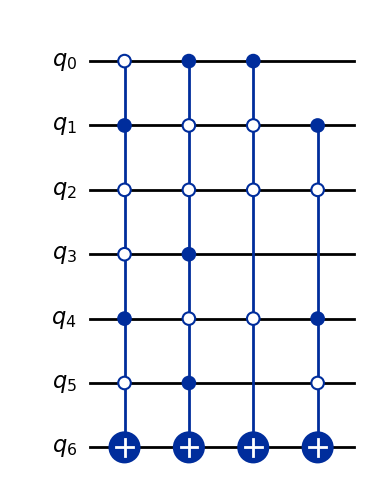

In [7]:
COMPILE_TYPE = CompileType.CLASSICAL_FUNCTION
oracle = problem.oracle(COMPILE_TYPE)
oracle.draw('mpl')

### Simulating the Oracle

In [8]:
import qiskit
from qiskit.circuit.library import grover_operator
from qiskit_aer import AerSimulator

# Build Grover circuit
grover_op = grover_operator(oracle, reflection_qubits=range(problem.num_vars))

search_circuit = qiskit.QuantumCircuit(oracle.num_qubits, problem.num_vars)

# Initialize superposition
search_circuit.h(range(problem.num_vars))

# Apply Grover operator
search_circuit.compose(grover_op.power(optimal_iterations), inplace=True)

# Measure
search_circuit.measure(range(problem.num_vars), range(problem.num_vars))

# Run simulation
simulator = AerSimulator()
qc = qiskit.transpile(search_circuit, simulator)
result = simulator.run(qc, shots=10**4).result()
counts = result.get_counts()

# Create trial
trial = ThreeSatTrial(
    instance_id=problem.instance_id,
    compile_type=COMPILE_TYPE,
    grover_iterations=optimal_iterations,
    job_id="simulation",
    simulation_counts=counts,
    counts=counts  # For simulation, counts and simulation_counts are the same
)

# Save trial
trial_id = benchmark_db.save_trial(trial)

# Calculate success rate
success_rate = benchmark_db.calculate_trial_success_rate(trial)
expected_rate = benchmark_db.calculate_trial_expected_success_rate(trial)

print(f"     Success rate: {success_rate:.3f} (expected: {expected_rate:.3f})")
print(f"     Trial ID: {trial.trial_id}")


     Success rate: 0.522 (expected: 0.646)
     Trial ID: 30


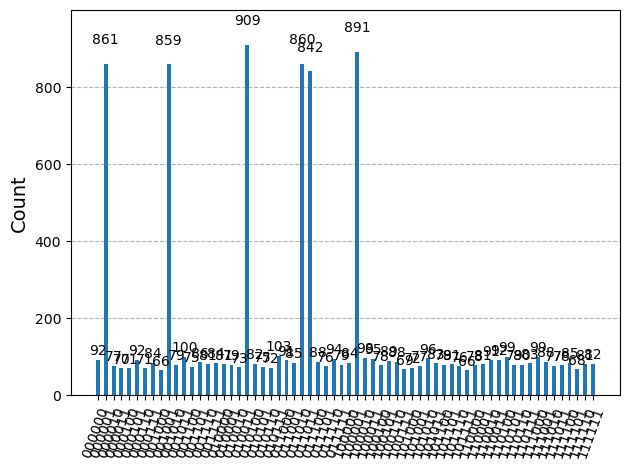

In [9]:
qiskit.visualization.plot_histogram(counts)